<a href="https://colab.research.google.com/github/chrisamz/142-Final-Project/blob/main/mysol_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
#import mcmc

In [16]:
def particle_gibbs(V,N,eps,delta=1,x0=None,hbar=1,m=1):
    """ Yeilds values of a sequence generated by Gibbs sampling on the
    heat-bath quantum particle.

    V           function of potential energy
    N           number of substeps
    eps         size of substeps
    
    delta       length of interval for the monte carlo walk step (default: 1)
    x0          initial position, length N array, excluding the x_N = x_0 point
                (default: array of zeros)
    hbar        value of h-bar (default: 1)
    m           value of mass (default: 1)
    """
    if x0 is None:
        x0 = np.zeros(N)
    
    stepdim = 0 # which dimension to sample from next

    tau = N*eps
    const_ke_coeff = m/(2*N*eps**2) #constant in front of the KE sum
    const_pe_coeff = 1/N            #constant in front of the PE sum

    E = (
        #KE - use average displacement (wrap around since motion periodic)
        const_ke_coeff*sum((x0 - np.roll(x0,1))**2)
        #PE - use each point
       +const_pe_coeff*sum(V(x0))
    )

    num_iters = 0
    num_accepts = 0

    while True:
        num_iters += 1
        #new point only along specific dimension
        xold = x0[stepdim]
        xnew = xold + (np.random.rand() - 0.5)*delta
        xleft = x0[(stepdim-1) % N]
        xright = x0[(stepdim+1) % N]
        #subtract old terms and add new terms inside exp
        
        E_diff = (
            const_ke_coeff*( (xnew - xleft)**2 - (xold - xleft)**2
                + (xright - xnew)**2 - (xright - xold)**2 )
           +const_pe_coeff*(V(xnew) - V(xold))
        )

        # x0[stepdim] = xnew
        # E_new = (
        #     #KE - use average displacement (wrap around since motion periodic)
        #     const_ke_coeff*sum((x0 - np.roll(x0,1))**2)
        #     #PE - use each point
        #     +const_pe_coeff*sum(V(x0))
        # )
        # x0[stepdim] = xold

        # Pnew/Pold = exp(-tau Enew/hbar)/exp(-tau Eold/hbar) = ...
        if np.random.rand() < np.exp(-tau/hbar*E_diff):
            x0[stepdim] = xnew
            E += E_diff
            num_accepts += 1

        yield x0,E,stepdim,x0[stepdim],num_accepts/num_iters
        stepdim = (stepdim + 1) % N


V = lambda x: (x**2 - 2)**2
dVdx = lambda x: 4*(x**2 - 2)*x
#V = lambda x: x**2/2
#dVdx = lambda x: x

#parameters
#tau = 1
N = 1000; eps = 0.01
tau = N * eps

delta = 4 * np.sqrt(eps)

#how many samples to iterate, but throw away
warm_up = 1000 * N

#number of samples to collect
collect_samples = 100000

#number of samples taken per one used
collect_interval = N


#keep energy values for each collection (don't store position values)
E_collect = np.empty(collect_samples)
samples_in_avg = 0
E_avg = 0
KE_avg = 0; PE_avg = 0
KE_avg2 = 0
x2_avg = 0
v2_avg1 = 0
v2_avg2 = 0

#collect x in bins
xmin = -4; xmax = 4; nbins = 100
bindx = (xmax - xmin)/nbins
X_binned = np.zeros(nbins,np.int64)



#use multiple independent walkers
num_runs = 1

#=====progress bar
progress_bar_num_parts = 100
print("Progress\n┌" + "─"*progress_bar_num_parts + "┐\n",end="│")
progress_bar_it = 0
#=================


for current_run in range(num_runs):

    #current sample
    n = -warm_up
    collect_wait = 0
    init_pos = (np.random.rand()-0.5) * 4
    for x,E,stepdim,xnew,accept_rate in particle_gibbs(V,N,eps,delta=delta,x0=np.zeros(N) + init_pos):
        if n < 0: #still in warm up
            n += 1
            continue
        #x is returned by reference, don't modify it because it is still in use
        
        #print("%.5f" % accept_rate,E,end="")
        if xmin <= xnew and xnew <= xmax:
            X_binned[int(np.floor((xnew-xmin)/bindx))] += 1
        
        samples_in_avg += 1
        E_avg = (E_avg*(samples_in_avg-1) + E)/samples_in_avg
        #PE = sum(V(x))/N
        KE_avg = (KE_avg*(samples_in_avg-1) + E - V(xnew))/samples_in_avg
        KE_avg2 = (KE_avg2*(samples_in_avg-1) + xnew*dVdx(xnew)/2)/samples_in_avg
        PE_avg = (PE_avg*(samples_in_avg-1) + V(xnew))/samples_in_avg
        x2_avg = (x2_avg*(samples_in_avg-1) + xnew**2)/samples_in_avg
        v2_avg1 = (v2_avg1*(samples_in_avg-1) + (xnew - x[(stepdim + 1) %N])**2/eps**2)/samples_in_avg
        v2_avg2 = (v2_avg2*(samples_in_avg-1) + (x[(stepdim - 1) %N] - x[(stepdim + 1) %N])**2/(4*eps**2))/samples_in_avg

        collect_wait += 1
        if collect_wait > collect_interval:
            collect_wait = 0
            n += 1
            # avg = sum_{k=1}^n (val_k)/n = sum_{k=1}^{n-1} (val_k)/n + val_n/n
            #     = old_avg*(n-1)/n + val_n/n

            #collect energy
            E_collect[n-1] = E

    #=====progress bar
            progress_bar_next = round(progress_bar_num_parts * (current_run*collect_samples + n)/(collect_samples*num_runs)) - progress_bar_it
            if progress_bar_next > 0:
                print("="*progress_bar_next,end="")
                progress_bar_it += progress_bar_next
    #=================

            if n >= collect_samples:
                break
print("│")
print(accept_rate)


Progress
┌────────────────────────────────────────────────────────────────────────────────────────────────────┐
│====================================================================================================│
0.5138315628090999


In [17]:
import matplotlib.pyplot as plt

print(f"E_avg = {E_avg}, KE_avg = {KE_avg}, PE_avg = {PE_avg}, x^2_avg = {x2_avg}")
print(f"KE_avg (virial) = {KE_avg2}, E_avg (KE virial + PE) = {KE_avg2 + PE_avg}")

E_avg = 50.16282252364013, KE_avg = 49.13967520456529, PE_avg = 1.023147319081778, x^2_avg = 1.7185897724860255
KE_avg (virial) = 0.9206537281027514, E_avg (KE virial + PE) = 1.9438010471845293


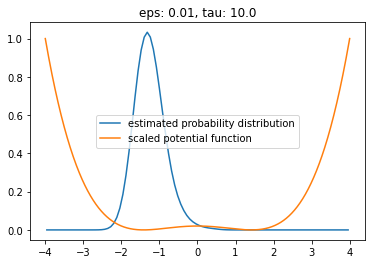

In [19]:
plt.figure(figsize=(16,10))
plt.title(f"eps: {eps}, tau: {tau}")
plt.plot(np.linspace(xmin+bindx/2,xmax-bindx/2,nbins),X_binned/sum(X_binned) / bindx,label="estimated probability distribution")
#plt.plot(np.linspace(xmin,xmax,1000), (1/np.pi)**0.5 * np.exp(-0.5*np.linspace(xmin,xmax,1000)**2)**2,"-.",label="analytic probability distribution")
plt.plot(np.linspace(xmin,xmax,1000),V(np.linspace(xmin,xmax,1000))/V(xmin),label="scaled potential function")
plt.legend()
plt.show()


In [ ]:
print(v2_avg1/2,v2_avg2/2)

4.745438267875033 2.255558622639686


In [ ]:
x = lambda t: abs(t - tau/2)


# const_ke_coeff = m/(2*N*eps**2) #constant in front of the KE sum
# const_pe_coeff = 1/N            #constant in front of the PE sum
# E_new = (
#         #KE - use average displacement (wrap around since motion periodic)
#         const_ke_coeff*sum((x0 - np.roll(x0,1))**2)
#         #PE - use each point
#         +const_pe_coeff*sum(V(x0))
# )
tau = 10

eps = 1; N = round(tau/eps); x0 = x(np.linspace(0,tau,N+1)[:-1])
print(
    #KE - use average displacement (wrap around since motion periodic)
    1/(2*N*eps**2)*sum((x0 - np.roll(x0,1))**2)
    #PE - use each point
    +1/N*sum(V(x0))
)
eps = 0.1; N = round(tau/eps); x0 = x(np.linspace(0,tau,N+1)[:-1])
print(
    #KE - use average displacement (wrap around since motion periodic)
    1/(2*N*eps**2)*sum((x0 - np.roll(x0,1))**2)
    #PE - use each point
    +1/N*sum(V(x0))
)

eps = .01; N = round(tau/eps); x0 = x(np.linspace(0,tau,N+1)[:-1])
print(
     #KE - use average displacement (wrap around since motion periodic)
     1/(2*N*eps**2)*sum((x0 - np.roll(x0,1))**2)
     #PE - use each point
    +1/N*sum(V(x0))
)


9.0
8.835000000000003
8.83334999999999


### (c)
Can you calculate the average energy  of the electron from the same simulation code when  is much lower than in (a)

In [36]:
V = lambda x : x**2
#parameters
#tau = 1
tau = 1
N = 10; eps = tau/N

delta = 4 * np.sqrt(eps)

#how many samples to iterate, but throw away
warm_up = 1000 * N

#number of samples to collect
collect_samples = 100000

#number of samples taken per one used
collect_interval = N


#keep energy values for each collection (don't store position values)
E_collect = np.empty(collect_samples)
samples_in_avg = 0
E_avg = 0
KE_avg = 0; PE_avg = 0
KE_avg2 = 0
x2_avg = 0
v2_avg1 = 0
v2_avg2 = 0

#collect x in bins
xmin = -4; xmax = 4; nbins = 100
bindx = (xmax - xmin)/nbins
X_binned = np.zeros(nbins,np.int64)



#use multiple independent walkers
num_runs = 1

#=====progress bar
progress_bar_num_parts = 100
print("Progress\n┌" + "─"*progress_bar_num_parts + "┐\n",end="│")
progress_bar_it = 0
#=================


for current_run in range(num_runs):

    #current sample
    n = -warm_up
    collect_wait = 0
    init_pos = (np.random.rand()-0.5) * 4
    for x,E,stepdim,xnew,accept_rate in particle_gibbs(V,N,eps,delta=delta,x0=np.zeros(N) + init_pos):
        if n < 0: #still in warm up
            n += 1
            continue
        #x is returned by reference, don't modify it because it is still in use
        
        #print("%.5f" % accept_rate,E,end="")
        if xmin <= xnew and xnew <= xmax:
            X_binned[int(np.floor((xnew-xmin)/bindx))] += 1
        
        samples_in_avg += 1
        E_avg = (E_avg*(samples_in_avg-1) + E)/samples_in_avg
        #PE = sum(V(x))/N
        KE_avg = (KE_avg*(samples_in_avg-1) + E - V(xnew))/samples_in_avg
        KE_avg2 = (KE_avg2*(samples_in_avg-1) + xnew*dVdx(xnew)/2)/samples_in_avg
        PE_avg = (PE_avg*(samples_in_avg-1) + V(xnew))/samples_in_avg
        x2_avg = (x2_avg*(samples_in_avg-1) + xnew**2)/samples_in_avg
        v2_avg1 = (v2_avg1*(samples_in_avg-1) + (xnew - x[(stepdim + 1) %N])**2/eps**2)/samples_in_avg
        v2_avg2 = (v2_avg2*(samples_in_avg-1) + (x[(stepdim - 1) %N] - x[(stepdim + 1) %N])**2/(4*eps**2))/samples_in_avg

        collect_wait += 1
        if collect_wait > collect_interval:
            collect_wait = 0
            n += 1
            # avg = sum_{k=1}^n (val_k)/n = sum_{k=1}^{n-1} (val_k)/n + val_n/n
            #     = old_avg*(n-1)/n + val_n/n

            #collect energy
            E_collect[n-1] = E

    #=====progress bar
            progress_bar_next = round(progress_bar_num_parts * (current_run*collect_samples + n)/(collect_samples*num_runs)) - progress_bar_it
            if progress_bar_next > 0:
                print("="*progress_bar_next,end="")
                progress_bar_it += progress_bar_next
    #=================

            if n >= collect_samples:
                break
print("│")
print(accept_rate)

Progress
┌────────────────────────────────────────────────────────────────────────────────────────────────────┐
│====================================================================================================│
0.5118


E_avg = 49.15109660810522, KE_avg = 45.0930902040887, PE_avg = 4.058006404016288, x^2_avg = 4.058006404016288
KE_avg (virial) = 92.49089296230164, E_avg (KE virial + PE) = 96.54889936631793


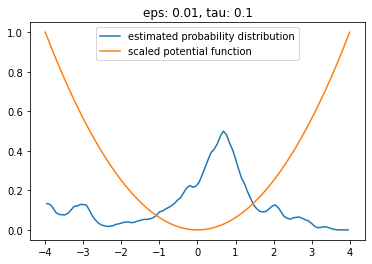

In [35]:

print(f"E_avg = {E_avg}, KE_avg = {KE_avg}, PE_avg = {PE_avg}, x^2_avg = {x2_avg}")
print(f"KE_avg (virial) = {KE_avg2}, E_avg (KE virial + PE) = {KE_avg2 + PE_avg}")
#plt.figure(figsize=(16,10))
plt.title(f"eps: {eps}, tau: {tau}")
plt.plot(np.linspace(xmin+bindx/2,xmax-bindx/2,nbins),X_binned/sum(X_binned) / bindx,label="estimated probability distribution")
#plt.plot(np.linspace(xmin,xmax,1000), (1/np.pi)**0.5 * np.exp(-0.5*np.linspace(xmin,xmax,1000)**2)**2,"-.",label="analytic probability distribution")
plt.plot(np.linspace(xmin,xmax,1000),V(np.linspace(xmin,xmax,1000))/V(xmin),label="scaled potential function")
plt.legend()
plt.show()
